In [23]:
import pandas as pd
import matplotlib.ticker as tick
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as pplt
import matplotlib.cm as cm
from matplotlib import lines
import datetime
import plotly.graph_objects as go
from matplotlib import rcParams as rcp

# Setting variables

In [24]:
#gene_name1 = input('Gene name 1: ')
gene_name1 = 'brca1'
#gene_name2 = input('Gene name 2 (if wanted, else press enter): ')
gene_name2 = 'brca2'

date = str(datetime.date.today())

# joint file of gene
df1 = pd.read_csv(gene_name1.lower() + '_joint_out.csv')
dfs = [df1]
gene_names = [gene_name1]
if gene_name2 != '':
    df2 = pd.read_csv(gene_name2.lower() + '_joint_out.csv')
    dfs.append(df2)
    gene_names.append(gene_name2)

# SIFT_VEP and PolyPhen_VEP combined str and float values -> create one column for each
for df in dfs:
    df[['SIFT_VEP_str', 'SIFT_VEP_num']] = df['SIFT_VEP'].str.split('(', expand = True)
    df['SIFT_VEP_num'] = df['SIFT_VEP_num'].str.strip(')').astype(float)
    df[['PolyPhen_VEP_str', 'PolyPhen_VEP_num']] = df['PolyPhen_VEP'].str.split('(', expand = True)
    df['PolyPhen_VEP_num'] = df['PolyPhen_VEP_num'].str.strip(')').astype(float)
    df['Consequence_VEP'] = df['Consequence_VEP'].str.replace('_', ' ')
    df['Consequence_VEP'] = df['Consequence_VEP'].str.replace(',', ', ')

C:\Users\alexa\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (43,47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [25]:
# coding sequences as df
coding_df1 = df1.loc[df1['Protein_position'].notnull()].copy()
coding_dfs = [coding_df1]
# unique positions (+ introns)
all_pos1 = list(df1['POS'].unique())
all_pos = [all_pos1]

if gene_name2 != '':
    coding_df2 = df2.loc[df2['Protein_position'].notnull()].copy()
    coding_dfs.append(coding_df2)
    all_pos2 = list(df2['POS'].unique())
    all_pos.append(all_pos2)

revs = []
for df, cod in zip(dfs, coding_dfs):
    if df.iloc[0]['Strand'] == '+':
        cod.sort_values(by = ['POS'], ascending = True, ignore_index = True, inplace = True)
        revs.append(False)
    elif df.iloc[0]['Strand'] == '-':
        cod.sort_values(by = ['POS'], ascending = False, ignore_index = True, inplace = True)
        revs.append(True)
    cod['Protein_position'] = cod['Protein_position'].astype(int)
    cod['POS'] = cod['POS'].astype(int)

# unique coding positions list
codpos1 = list(coding_df1['POS'].unique())
codpos = [codpos1]
if gene_name2 != '':
    codpos2 = list(coding_df2['POS'].unique())
    codpos.append(codpos2)

for pos,cpos,r in zip(all_pos, codpos, revs):
    pos.sort(reverse = r)
    cpos.sort(reverse = r)

In [26]:
# search for exon start/stop
tuple_exons = []
for df, cpos in zip(dfs, codpos):
    exons_beg = []
    exons_end = []
    tuple_exons_in = []
    if df.iloc[0]['Strand'] == '+':
        for el in cpos:
            if el-1 not in cpos:
                exons_beg.append(el)
            elif el+1 not in cpos:
                exons_end.append(el)
            else:
                continue
    elif df.iloc[0]['Strand'] == '-':
        for el in cpos:
            if el+1 not in cpos:
                exons_beg.append(el)
            elif el-1 not in cpos:
                exons_end.append(el)
            else:
                continue
    else:
        pass
    for x, y in zip(exons_beg, exons_end):
        tuple_exons_in.append((x,y))
    tuple_exons.append(tuple_exons_in)

tuple_exons1 = tuple_exons[0]
if len(tuple_exons) > 1:
    tuple_exons2 = tuple_exons[1]

# Overview of gene

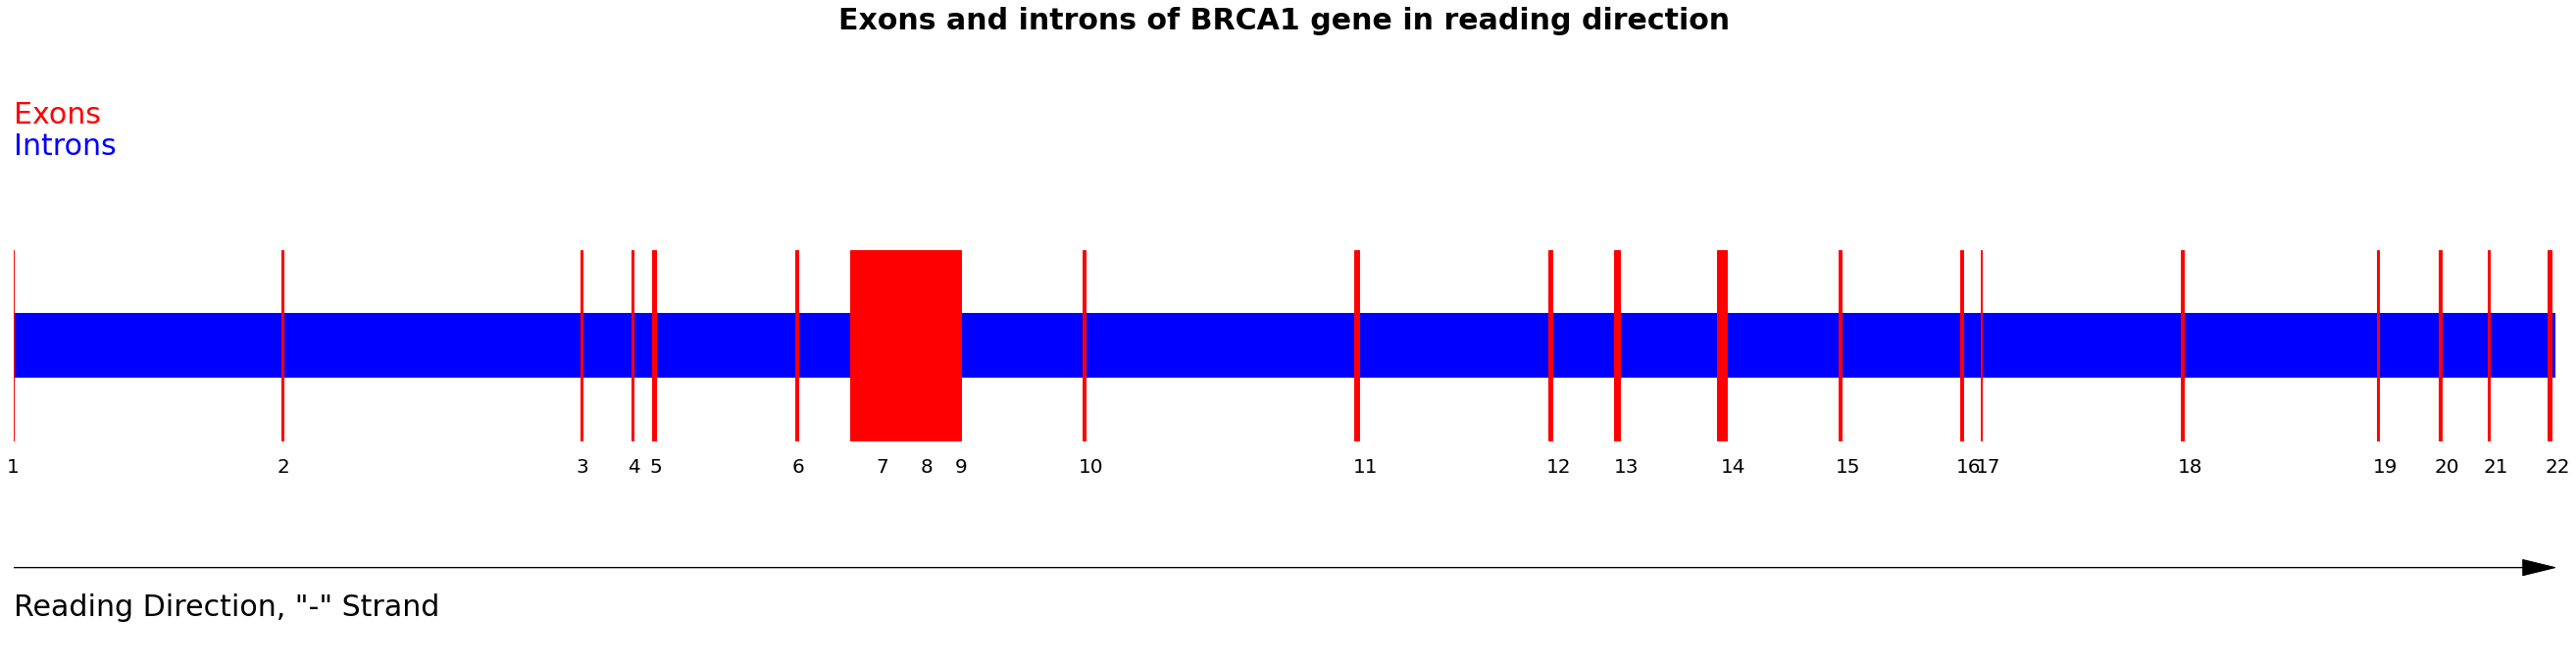

In [27]:
# exons and introns for 1st gene
fig,ax = plt.subplots(figsize=(40, 10))
plt.ylim([-1, 1])
plt.axis('off')
fig.suptitle('Exons and introns of ' + gene_name1.upper() + ' gene in reading direction', fontsize = 30, fontweight = 'bold')
plt.xlim(tuple_exons1[0][0], tuple_exons1[-1][1])
if df1.iloc[0]['Strand'] == '+':
    ax.add_patch(pplt.Rectangle((tuple_exons1[0][0], -.1), tuple_exons1[-1][1], .2, fc = 'blue', ec = 'blue', alpha = 1, label = 'Introns'))
    ax.arrow(tuple_exons1[0][0], -0.7, abs(tuple_exons1[-1][1]-tuple_exons1[0][0])-1000, 0, head_width = 0.05, head_length = 1000, fc = 'k', ec = 'k')
    for tup,l in zip(tuple_exons1, range(len(tuple_exons1))):
        ax.add_patch(pplt.Rectangle((int(tup[0]), -.3), abs(int(tup[0])-int(tup[1])), .6, fc = 'red', ec = 'red', alpha = 1))
        plt.text(int(tup[0]), -.4, str((int(l)+1)), size = 20)
elif df1.iloc[0]['Strand'] == '-':
    ax.add_patch(pplt.Rectangle((tuple_exons1[-1][1], -.1), tuple_exons1[0][0], .2, fc = 'blue', ec = 'blue', alpha = 1, label = 'Introns'))
    ax.arrow(tuple_exons1[0][0], -0.7, -abs(tuple_exons1[-1][1]-tuple_exons1[0][0])+1000, 0, head_width = 0.05, head_length = 1000, fc = 'k', ec = 'k')
    for tup,l in zip(tuple_exons1, range(len(tuple_exons1))):
        ax.add_patch(pplt.Rectangle((int(tup[0]), -.3), abs(int(tup[0])-int(tup[1])), .6, fc = 'red', ec = 'red', alpha = 1))
        plt.text(int(tup[0]+200), -.4, str((int(l)+1)), size = 20)

plt.text(tuple_exons1[0][0], 0.7, 'Exons', c = 'red', size = 30)
plt.text(tuple_exons1[0][0], 0.6, 'Introns', c = 'blue', size = 30)

plt.text(tuple_exons1[0][0], -0.85, 'Reading Direction, "' + str(df1.iloc[0]['Strand']) + '" Strand', size = 30)
plt.gcf().subplots_adjust(bottom = 0.05, top = 0.95, left = 0.05, right = 0.95);

plt.savefig(date + '_' + gene_name1.lower() + '_exins_ov.pdf')
plt.savefig(date + '_' + gene_name1.lower() + '_exins_ov.jpg')

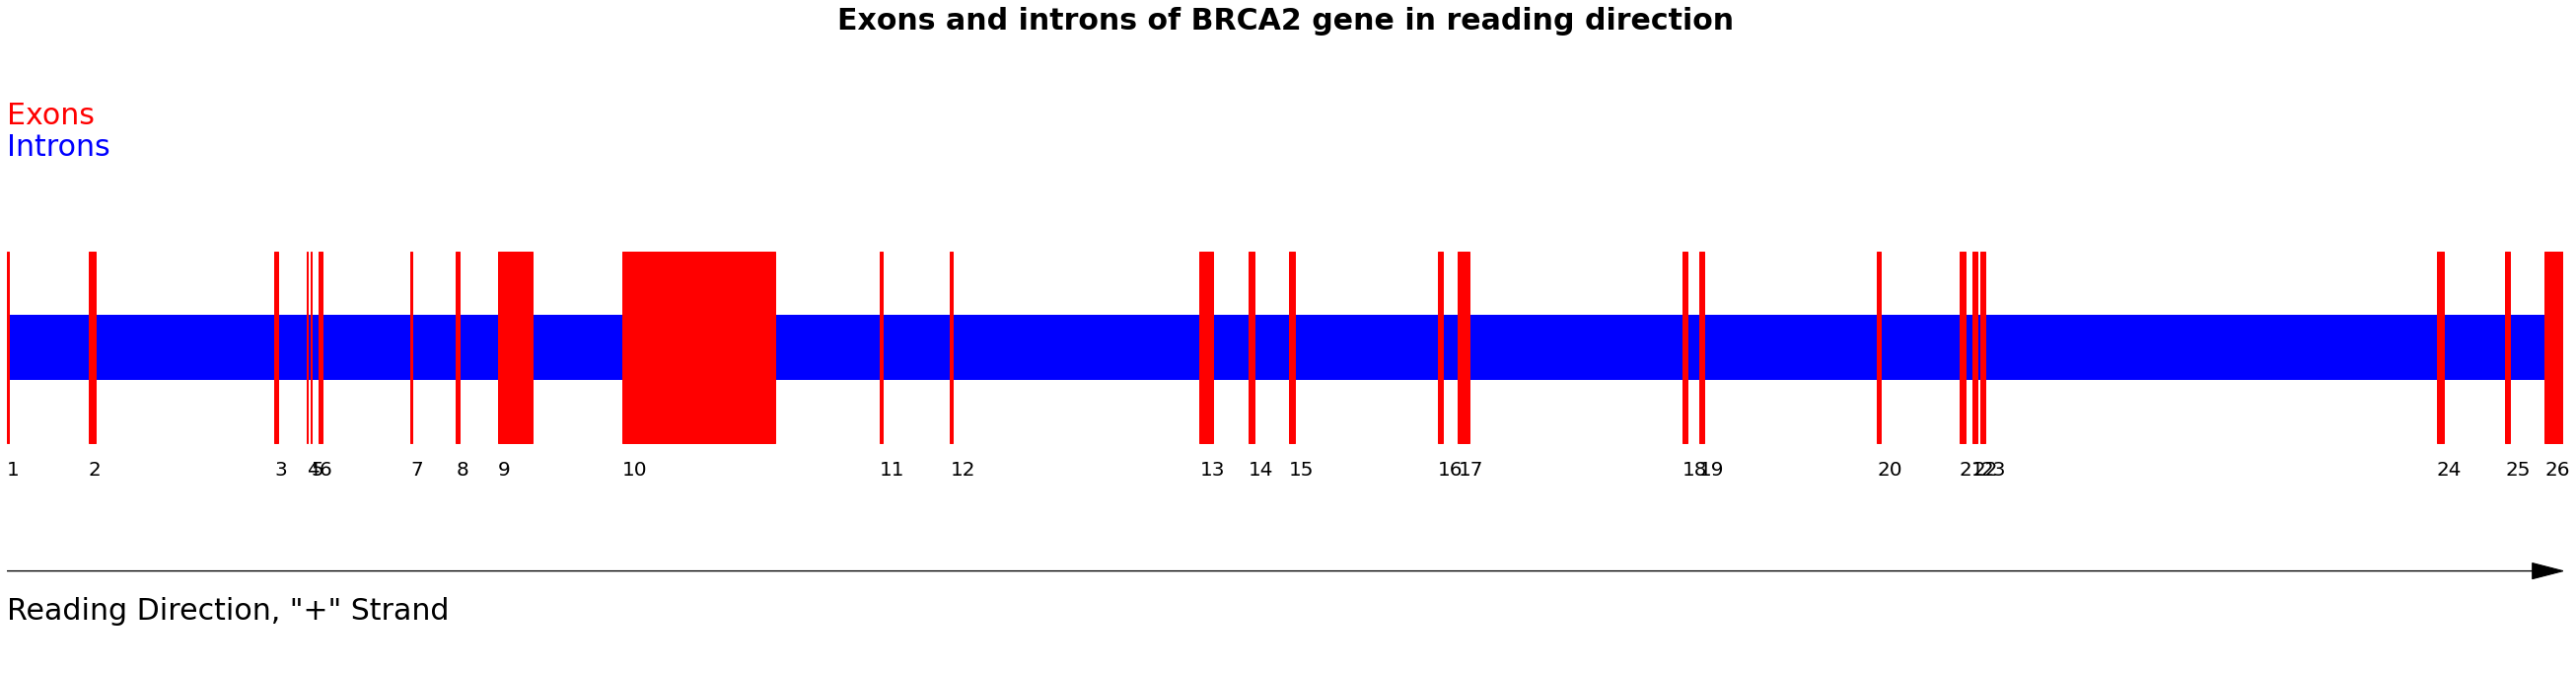

In [28]:
# exons and introns for 2nd gene
if gene_name2 != '':
    fig,ax = plt.subplots(figsize=(40, 10))
    plt.ylim([-1, 1])
    plt.axis('off')
    fig.suptitle('Exons and introns of ' + gene_name2.upper() + ' gene in reading direction', fontsize = 30, fontweight = 'bold')
    plt.xlim(tuple_exons2[0][0], tuple_exons2[-1][1])
    if df2.iloc[0]['Strand'] == '+':
        ax.add_patch(pplt.Rectangle((tuple_exons2[0][0], -.1), tuple_exons2[-1][1], .2, fc = 'blue', ec = 'blue', alpha = 1, label = 'Introns'))
        ax.arrow(tuple_exons2[0][0], -0.7, abs(tuple_exons2[-1][1]-tuple_exons2[0][0])-1000, 0, head_width = 0.05, head_length = 1000, fc = 'k', ec = 'k')
        for tup,l in zip(tuple_exons2, range(len(tuple_exons2))):
            ax.add_patch(pplt.Rectangle((int(tup[0]), -.3), abs(int(tup[0])-int(tup[1])), .6, fc = 'red', ec = 'red', alpha = 1))
            plt.text(int(tup[0]), -.4, str((int(l)+1)), size = 20)
    elif df2.iloc[0]['Strand'] == '-':
        ax.add_patch(pplt.Rectangle((tuple_exons2[-1][1], -.1), tuple_exons2[0][0], .2, fc = 'blue', ec = 'blue', alpha = 1, label = 'Introns'))
        ax.arrow(tuple_exons2[0][0], -0.7, -abs(tuple_exons2[-1][1]-tuple_exons2[0][0])+1000, 0, head_width = 0.05, head_length = 1000, fc = 'k', ec = 'k')
        for tup,l in zip(tuple_exons2, range(len(tuple_exons2))):
            ax.add_patch(pplt.Rectangle((int(tup[0]), -.3), abs(int(tup[0])-int(tup[1])), .6, fc = 'red', ec = 'red', alpha = 1))
            plt.text(int(tup[0]+200), -.4, str((int(l)+1)), size = 20)

    plt.text(tuple_exons2[0][0], 0.7, 'Exons', c = 'red', size = 30)
    plt.text(tuple_exons2[0][0], 0.6, 'Introns', c = 'blue', size = 30)

    plt.text(tuple_exons2[0][0], -0.85, 'Reading Direction, "' + str(df2.iloc[0]['Strand']) + '" Strand', size = 30)
    plt.gcf().subplots_adjust(bottom = 0.05, top = 0.95, left = 0.05, right = 0.95);

    plt.savefig(date + '_' + gene_name2.lower() + '_exins_ov.pdf')
    plt.savefig(date + '_' + gene_name2.lower() + '_exins_ov.jpg')
else:
    pass

# Overview of annotations

In [29]:
# for pie chart with origin of variants, plus info of exon/intron
# 1st gene
sizes = []
labels = []
cols = []
sizes_sg = []
labels_sg = []
cols_sg = []

for df in dfs:
    sizes.append([len(df[df['AC_gnomAD'].notnull() & df['ClinVar_gnomAD'].notnull()]), 
                  len(df[df['AC_gnomAD'].notnull() & df['ClinVar_gnomAD'].isnull()]), 
                  len(df[df['Cancer_Type_cBP'].notnull()]),
                  len(df[df['Trans_Version_Flossies'].notnull()]), 
                  len(df[df['NCT_SAMPLE_NAME'].notnull()]), 
                 ])
    labels.append(['GnomAD (+ ClinVar)',
                    'GnomAD (w/o ClinVar)',
                    'cBioPortal',
                    'Flossies',
                    'MASTER/NCT project',
                  ])
    cols.append(['red', 'orange', 'green', 'dodgerblue', 'magenta'])
    sizes_sg.append([len(df[df['AC_gnomAD'].notnull() & df['ClinVar_gnomAD'].notnull() & df['EXON'].notnull()]), 
            len(df[df['AC_gnomAD'].notnull() & df['ClinVar_gnomAD'].notnull() & df['EXON'].isnull()]), 
            len(df[df['AC_gnomAD'].notnull() & df['ClinVar_gnomAD'].isnull() & df['EXON'].notnull()]), 
            len(df[df['AC_gnomAD'].notnull() & df['ClinVar_gnomAD'].isnull() & df['EXON'].isnull()]), 
            len(df[df['Cancer_Type_cBP'].notnull() & df['EXON'].notnull()]), 
            len(df[df['Cancer_Type_cBP'].notnull() & df['EXON'].isnull()]), 
            len(df[df['Trans_Version_Flossies'].notnull() & df['EXON'].notnull()]), 
            len(df[df['Trans_Version_Flossies'].notnull() & df['EXON'].isnull()]), 
            len(df[df['NCT_SAMPLE_NAME'].notnull() & df['EXON'].notnull()]),
            len(df[df['NCT_SAMPLE_NAME'].notnull() & df['EXON'].isnull()]),
           ])
    labels_sg.append(['E', 'I', 'E', 'I', 'E', 'I', 'E', 'I', 'E', 'I'])
    cols_sg.append(['lightcoral', 'lightsalmon', 'gold', 'bisque', 'chartreuse', 'palegreen', 
          'deepskyblue', 'lightskyblue', 'violet', 'lightpink'])

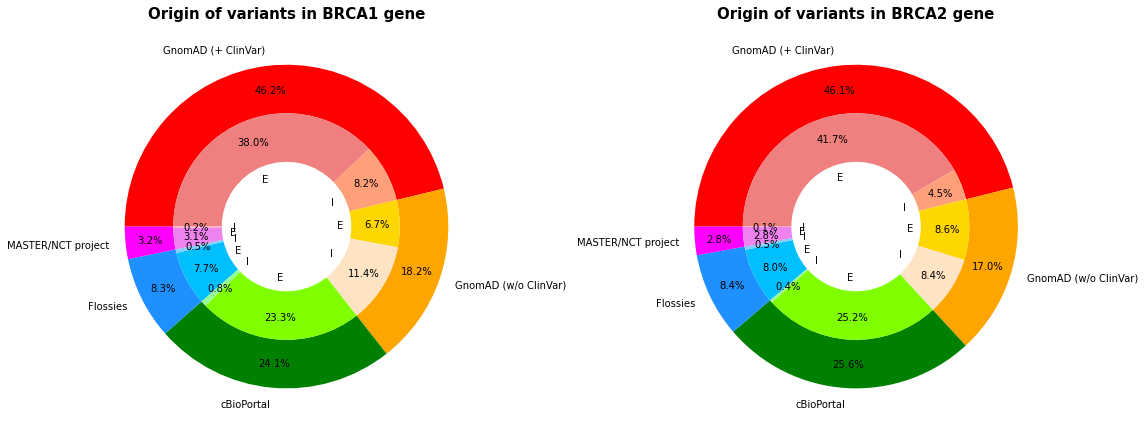

In [31]:
fig = plt.subplots(figsize=(16, 8))
# pie plot in coding sequence + 75 bp padding for gene 1, exon vs. intron
if gene_name2 != '':
    ax1 = plt.subplot(1,2,1)
else:
    ax1 = plt.subplot(1,1,1)
ax1.set_title('Origin of variants in ' + gene_name1.upper() + ' gene', fontsize = 15, fontweight = 'bold')
ax1.pie(sizes[0], labels = labels[0], autopct = '%1.1f%%', startangle = 180, pctdistance = 0.85, 
        colors = cols[0], counterclock = False, radius = 1, wedgeprops = dict(width = 0.3))
ax1.pie(sizes_sg[0], autopct = '%1.1f%%', startangle = 180, pctdistance = 0.8, 
            labels = labels_sg[0], labeldistance = 0.45, colors = cols_sg[0], 
            counterclock = False, radius = 0.7, wedgeprops = dict(width = 0.3));

# pie plot in coding sequence + 75 bp padding for gene 2, exon vs. intron
if gene_name2 != '':
    ax2 = plt.subplot(1,2,2)
    ax2.set_title('Origin of variants in ' + gene_name2.upper() + ' gene', fontsize = 15, fontweight = 'bold')
    ax2.pie(sizes[1], labels = labels[1], autopct = '%1.1f%%', startangle = 180, pctdistance = 0.85, 
                colors = cols[1], counterclock = False, radius = 1, wedgeprops = dict(width = 0.3))
    ax2.pie(sizes_sg[1], autopct = '%1.1f%%', startangle = 180, pctdistance = 0.8, 
                labels = labels_sg[1], labeldistance = 0.45, colors = cols_sg[1], 
                counterclock = False, radius = 0.7, wedgeprops = dict(width = 0.3));
    plt.tight_layout()
    plt.savefig(date + '_' + gene_name1.lower() + '_' + gene_name2.lower() + '_orig_vars.pdf')
    plt.savefig(date + '_' + gene_name1.lower() + '_' + gene_name2.lower() + '_orig_vars.jpg')
else:
    plt.tight_layout()
    plt.savefig(date + '_' + gene_name1.lower() + '_orig_vars.pdf')
    plt.savefig(date + '_' + gene_name1.lower() + '_orig_vars.jpg')

# Overview of ClinVar/VEP impact

In [32]:
# for pathogenicity by ClinVar, all, exons, introns
path1_val = df1['ClinVar_gnomAD'][df1['ClinVar_gnomAD'].notnull()].value_counts()
path1_val_df = pd.DataFrame(path1_val)
path1_val_ex1_df = pd.DataFrame(df1['ClinVar_gnomAD'][(df1['ClinVar_gnomAD'].notnull()) &
                                      (df1['EXON'].notnull())].value_counts())
path1_val_in1_df = pd.DataFrame(df1['ClinVar_gnomAD'][(df1['ClinVar_gnomAD'].notnull()) &
                                      (df1['INTRON'].notnull())].value_counts())
# for impact by VEP
imp1 = df1['Consequence_VEP'][df1['Consequence_VEP'].notnull()].value_counts()

# for gene 2
if gene_name2 != '':
    path2_val = df2['ClinVar_gnomAD'][df2['ClinVar_gnomAD'].notnull()].value_counts()
    path2_val_df = pd.DataFrame(path2_val)
    path2_val_ex2_df = pd.DataFrame(df2['ClinVar_gnomAD'][(df2['ClinVar_gnomAD'].notnull()) &
                                          (df2['EXON'].notnull())].value_counts())
    path2_val_in2_df = pd.DataFrame(df2['ClinVar_gnomAD'][(df2['ClinVar_gnomAD'].notnull()) &
                                          (df2['INTRON'].notnull())].value_counts())
    imp2 = df2['Consequence_VEP'][df2['Consequence_VEP'].notnull()].value_counts()

In [33]:
for el in [path1_val_df, path1_val_ex1_df, path1_val_in1_df, path2_val_df, path2_val_ex2_df, path2_val_in2_df]:
    el['index_1'] = el.index
all_pat1_df = path1_val_df.merge(path1_val_ex1_df, on = 'index_1', suffixes = ['_all1', '_ex1']
                  ).merge(path1_val_in1_df, on = 'index_1')
all_pat1_df = all_pat1_df.rename(columns = {'ClinVar_gnomAD':'ClinVar_gnomAD_in1'})
all_pat2_df = path2_val_df.merge(path2_val_ex2_df, on = 'index_1', suffixes = ['_all2', '_ex2']
                  ).merge(path2_val_in2_df, on = 'index_1')
all_pat2_df = all_pat2_df.rename(columns = {'ClinVar_gnomAD':'ClinVar_gnomAD_in2'})
# --> with these stacked bar plot

In [34]:
# for impact in introns/exons
imp_in1 = df1['Consequence_VEP'][(df1['Consequence_VEP'].notnull()) & 
                                 (df1['INTRON'].notnull())].value_counts()
imp_ex1 = df1['Consequence_VEP'][(df1['Consequence_VEP'].notnull()) &
                                 (df1['EXON'].notnull())].value_counts()

col1_imp1 = []
for el in imp1.index:
    if el in imp_in1.index and not el in imp_ex1.index:
        col1_imp1.append('orange')
    elif el in imp_ex1.index and not el in imp_in1.index:
        col1_imp1.append('dodgerblue')
    elif el in imp_in1.index and el in imp_ex1.index:
        col1_imp1.append('magenta')

if gene_name2 != '':
    imp_in2 = df2['Consequence_VEP'][(df2['Consequence_VEP'].notnull()) &
                                     (df2['INTRON'].notnull())].value_counts()
    imp_ex2 = df2['Consequence_VEP'][(df2['Consequence_VEP'].notnull()) &
                                     (df2['EXON'].notnull())].value_counts()
    col2_imp2 = []
    for el in imp2.index:
        if el in imp_in2.index and not el in imp_ex2.index:
            col2_imp2.append('orange')
        elif el in imp_ex2.index and not el in imp_in2.index:
            col2_imp2.append('dodgerblue')
        elif el in imp_in2.index and el in imp_ex2.index:
            col2_imp2.append('magenta')

<ipython-input-35-526fe9289240>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(imp1.index, rotation = 45, ha = 'right')
<ipython-input-35-526fe9289240>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(path1_val.index, rotation = 45, ha = 'right')
<ipython-input-35-526fe9289240>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(imp2.index, rotation = 45, ha = 'right')
<ipython-input-35-526fe9289240>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(path2_val.index, rotation = 45, ha = 'right')


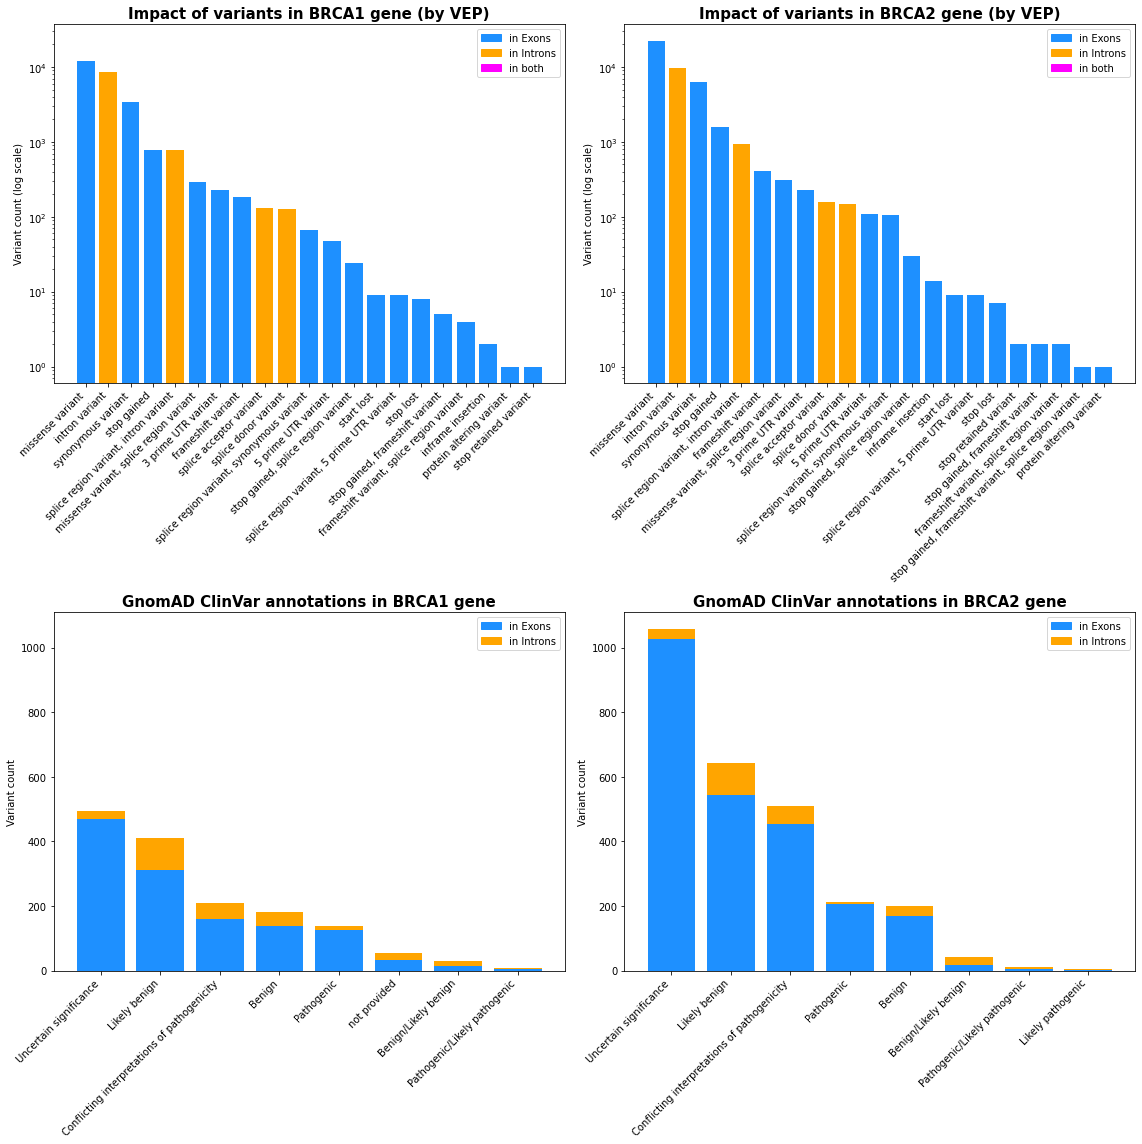

In [35]:
fig = plt.subplots(figsize=(16, 16))
if gene_name2 != '':
    ax1 = plt.subplot(2,2,1)
    ax3 = plt.subplot(2,2,3)
else:
    ax1 = plt.subplot(2,1,1)
    ax3 = plt.subplot(2,1,2)

blue_leg = pplt.Patch(color = 'dodgerblue', label = 'in Exons')
or_leg = pplt.Patch(color = 'orange', label = 'in Introns')
mag_leg = pplt.Patch(color = 'magenta', label = 'in both')

# impact of variants gene 1
ax1.set_title('Impact of variants in ' + gene_name1.upper() + ' gene (by VEP)', fontsize = 15, fontweight = 'bold')
ax1.bar(imp1.index, imp1.values, color = col1_imp1)
ax1.set_xticklabels(imp1.index, rotation = 45, ha = 'right')
ax1.set_ylabel('Variant count (log scale)')
ax1.set_yscale('log')
ax1.legend(handles = [blue_leg, or_leg, mag_leg])

# pathogenicity gene 1
ax3.set_title('GnomAD ClinVar annotations in ' + gene_name1.upper() + ' gene', fontsize = 15, fontweight = 'bold')
ax3.bar(all_pat1_df['index_1'], all_pat1_df['ClinVar_gnomAD_ex1'], 
       label = 'exons', color = 'dodgerblue')
ax3.bar(all_pat1_df['index_1'], all_pat1_df['ClinVar_gnomAD_in1'],
        label = 'introns', bottom = all_pat1_df['ClinVar_gnomAD_ex1'], 
        color = 'orange')
ax3.set_xticklabels(path1_val.index, rotation = 45, ha = 'right')
ax3.set_ylabel('Variant count')
#ax3.set_yscale('log')
ax3.legend(handles = [blue_leg, or_leg])

if gene_name2 != '':
    # impact of variants gene 2
    ax2 = plt.subplot(2,2,2, sharey = ax1)
    ax2.set_title('Impact of variants in ' + gene_name2.upper() + ' gene (by VEP)', fontsize = 15, fontweight = 'bold')
    ax2.bar(imp2.index, imp2.values, color = col2_imp2)
    ax2.set_xticklabels(imp2.index, rotation = 45, ha = 'right')
    ax2.set_ylabel('Variant count (log scale)')
    ax2.set_yscale('log')
    ax2.legend(handles = [blue_leg, or_leg, mag_leg])
    # pathogenicity gene 2
    ax4 = plt.subplot(2,2,4, sharey = ax3)
    ax4.set_title('GnomAD ClinVar annotations in ' + gene_name2.upper() + ' gene', fontsize = 15, fontweight = 'bold')
    ax4.bar(all_pat2_df['index_1'], all_pat2_df['ClinVar_gnomAD_ex2'], 
       label = 'exons', color = 'dodgerblue')
    ax4.bar(all_pat2_df['index_1'], all_pat2_df['ClinVar_gnomAD_in2'],
        label = 'introns', bottom = all_pat2_df['ClinVar_gnomAD_ex2'], 
        color = 'orange')
    ax4.set_xticklabels(path2_val.index, rotation = 45, ha = 'right')
    ax4.set_ylabel('Variant count')
    #ax4.set_yscale('log')
    ax4.legend(handles = [blue_leg, or_leg]);
    plt.tight_layout()
    plt.savefig(date + '_' + gene_name1.lower() + '_' + gene_name2.lower() + '_vars_cons_impact.pdf')
    plt.savefig(date + '_' + gene_name1.lower() + '_' + gene_name2.lower() + '_vars_cons_impact.jpg')
else:
    plt.tight_layout()
    plt.savefig(date + '_' + gene_name1.lower() + '_vars_cons_impact.pdf')
    plt.savefig(date + '_' + gene_name1.lower() + '_vars_cons_impact.jpg')
    


# Consequences of pathogenic variants, ClinVar of most common variants

In [36]:
# consequences of pathogenic variants
cons_pat1 = df1['Consequence_VEP'][df1['ClinVar_gnomAD'] == 'Pathogenic'].value_counts()
# clinvar annotations of most common consequence
clinv_miss1 = df1['ClinVar_gnomAD'][df1['Consequence_VEP'] == 'missense variant'].value_counts()

if gene_name2 != '':
    cons_pat2 = df2['Consequence_VEP'][df2['ClinVar_gnomAD'] == 'Pathogenic'].value_counts()
    clinv_miss2 = df2['ClinVar_gnomAD'][df2['Consequence_VEP'] == 'missense variant'].value_counts()

<ipython-input-37-47535151c293>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_xticklabels(cons_pat1.index, rotation = 45, ha = 'right')
<ipython-input-37-47535151c293>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(clinv_miss1.index, rotation = 45, ha = 'right')
<ipython-input-37-47535151c293>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax6.set_xticklabels(cons_pat2.index, rotation = 45, ha = 'right')
<ipython-input-37-47535151c293>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(clinv_miss2.index, rotation = 45, ha = 'right')


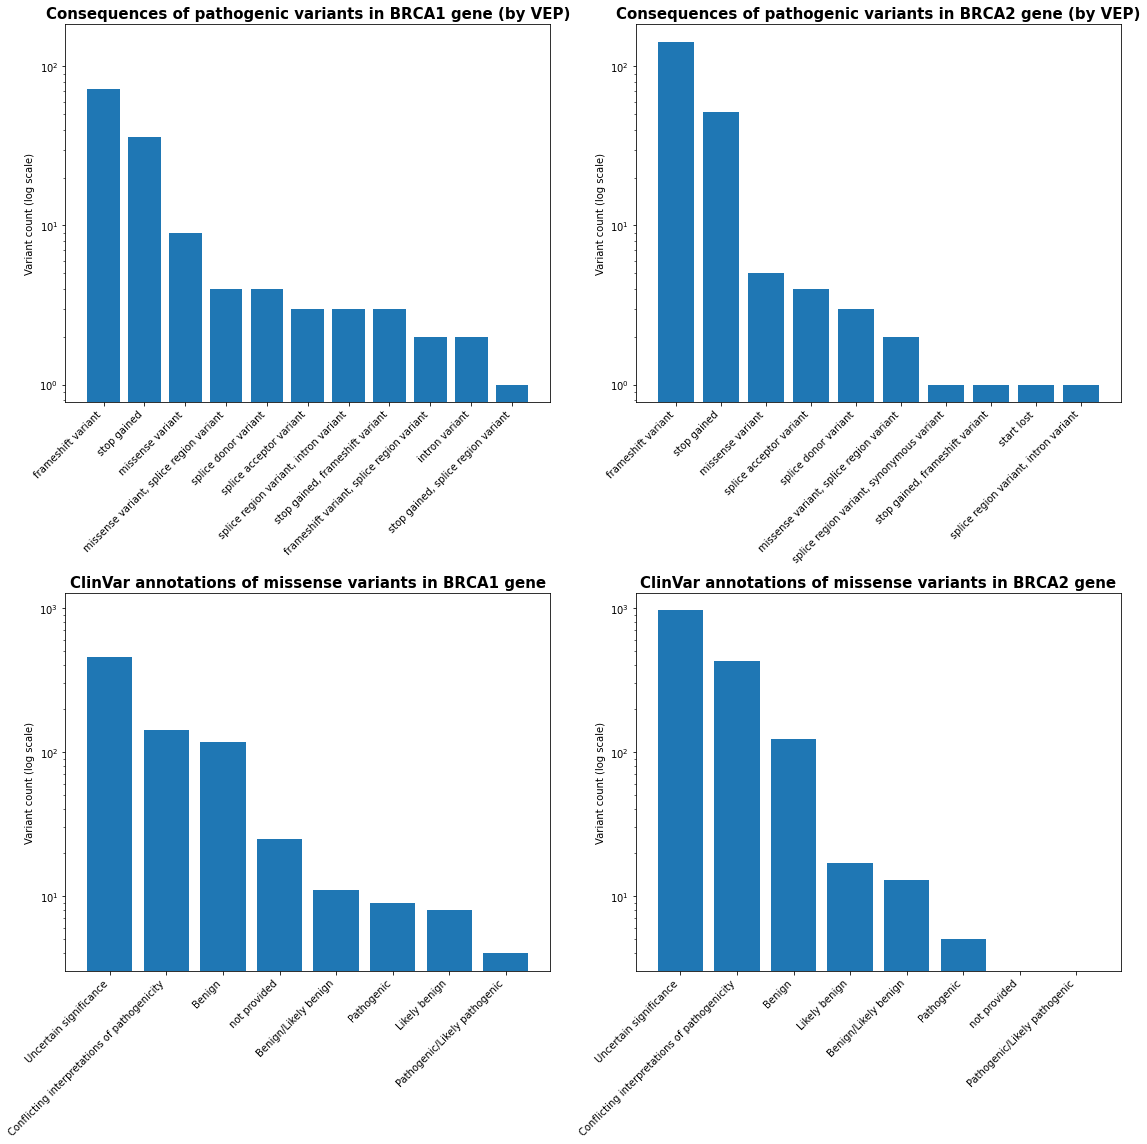

In [37]:
fig = plt.subplots(figsize=(16, 16))
if gene_name2 != '':
    ax5 = plt.subplot(2,2,1)
    ax3 = plt.subplot(2,2,3)
else:
    ax5 = plt.subplot(2,1,1)
    ax3 = plt.subplot(2,1,2)
# consequences of pathogenic variants gene 1
ax5.set_title('Consequences of pathogenic variants in ' + gene_name1.upper() + ' gene (by VEP)', fontsize = 15, fontweight = 'bold')
ax5.bar(cons_pat1.index, cons_pat1.values)
ax5.set_xticklabels(cons_pat1.index, rotation = 45, ha = 'right')
ax5.set_ylabel('Variant count (log scale)')
ax5.set_yscale('log')
# clinvar annotations in most common consequence in gene 1
ax3.set_title('ClinVar annotations of missense variants in ' + gene_name1.upper() + ' gene', fontsize = 15, fontweight = 'bold')
ax3.bar(clinv_miss1.index, clinv_miss1.values)
ax3.set_xticklabels(clinv_miss1.index, rotation = 45, ha = 'right')
ax3.set_ylabel('Variant count (log scale)')
ax3.set_yscale('log')

if gene_name2 != '':
    # consequences of pathogenic variants gene 2
    ax6 = plt.subplot(2,2,2, sharey = ax5)
    ax6.set_title('Consequences of pathogenic variants in ' + gene_name2.upper() + ' gene (by VEP)', fontsize = 15, fontweight = 'bold')
    ax6.bar(cons_pat2.index, cons_pat2.values)
    ax6.set_xticklabels(cons_pat2.index, rotation = 45, ha = 'right')
    ax6.set_ylabel('Variant count (log scale)')
    ax6.set_yscale('log')
    # clinvar annotations in most common consequence in gene 2
    ax4 = plt.subplot(2,2,4, sharey = ax3)
    ax4.set_title('ClinVar annotations of missense variants in ' + gene_name2.upper() + ' gene', fontsize = 15, fontweight = 'bold')
    ax4.bar(clinv_miss2.index, clinv_miss2.values)
    ax4.set_xticklabels(clinv_miss2.index, rotation = 45, ha = 'right')
    ax4.set_ylabel('Variant count (log scale)')
    ax4.set_yscale('log')
    plt.tight_layout();
    plt.savefig(date + '_' + gene_name1.lower() + '_' + gene_name2.lower() + '_path_miss.pdf')
    plt.savefig(date + '_' + gene_name1.lower() + '_' + gene_name2.lower() + '_path_miss.jpg')
else:
    plt.tight_layout()
    plt.savefig(date + '_' + gene_name1.lower() + '_path_miss.pdf')
    plt.savefig(date + '_' + gene_name1.lower() + '_path_miss.jpg')

## Location of as pathogenic characterized variants

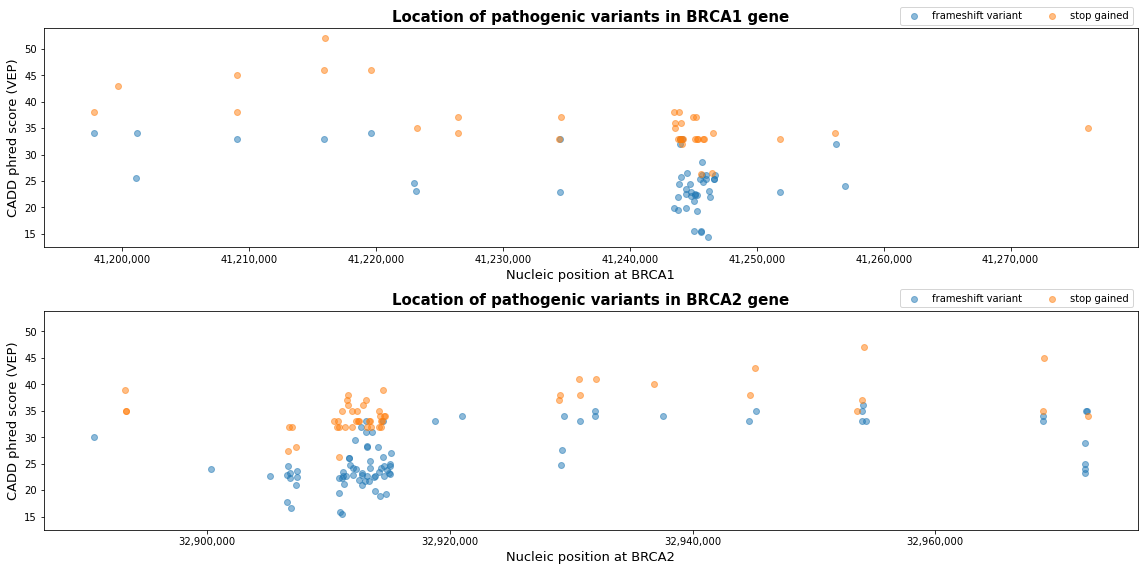

In [38]:
fig = plt.subplots(figsize=(16, 8))
if gene_name2 != '':
    ax1 = plt.subplot(2,1,1)
else:
    ax1 = plt.subplot(1,1,1)
# location of pathogenic variants with frameshift/stop gained gene 1
ax1.set_title('Location of pathogenic variants in ' + gene_name1.upper() + ' gene', fontsize = 15, fontweight = 'bold')
ax1.scatter(x = df1['POS'][(df1['ClinVar_gnomAD'] == 'Pathogenic') &
                           (df1['Consequence_VEP'] == 'frameshift variant')], 
            y = df1['CADD_PHRED_VEP'][(df1['ClinVar_gnomAD'] == 'Pathogenic') &
                                       (df1['Consequence_VEP'] == 'frameshift variant')], 
            alpha = 0.5, label = 'frameshift variant')
ax1.scatter(x = df1['POS'][(df1['ClinVar_gnomAD'] == 'Pathogenic') &
                           (df1['Consequence_VEP'] == 'stop gained')], 
            y = df1['CADD_PHRED_VEP'][(df1['ClinVar_gnomAD'] == 'Pathogenic') &
                                      (df1['Consequence_VEP'] == 'stop gained')], 
            alpha = 0.5, label = 'stop gained')
ax1.set_xlabel('Nucleic position at ' + gene_name1.upper(), fontsize = 13)
ax1.set_ylabel('CADD phred score (VEP)', fontsize = 13)
ax1.ticklabel_format(style = 'plain')
ax1.get_xaxis().set_major_formatter(tick.StrMethodFormatter('{x:,.0f}'))
plt.legend(bbox_to_anchor = (1, 1.12), ncol = 2)


if gene_name2 != '':
    # consequences of pathogenic variants gene 2
    ax2 = plt.subplot(2,1,2, sharey = ax1)
    ax2.set_title('Location of pathogenic variants in ' + gene_name2.upper() + ' gene', fontsize = 15, fontweight = 'bold')
    ax2.scatter(x = df2['POS'][(df2['ClinVar_gnomAD'] == 'Pathogenic') &
                               (df2['Consequence_VEP'] == 'frameshift variant')], 
                y = df2['CADD_PHRED_VEP'][(df2['ClinVar_gnomAD'] == 'Pathogenic') &
                                           (df2['Consequence_VEP'] == 'frameshift variant')], 
                alpha = 0.5, label = 'frameshift variant')
    ax2.scatter(x = df2['POS'][(df2['ClinVar_gnomAD'] == 'Pathogenic') &
                               (df2['Consequence_VEP'] == 'stop gained')], 
                y = df2['CADD_PHRED_VEP'][(df2['ClinVar_gnomAD'] == 'Pathogenic') &
                                          (df2['Consequence_VEP'] == 'stop gained')], 
                alpha = 0.5, label = 'stop gained')
    ax2.set_xlabel('Nucleic position at ' + gene_name2.upper(), fontsize = 13)
    ax2.set_ylabel('CADD phred score (VEP)', fontsize = 13)
    ax2.ticklabel_format(style = 'plain')
    ax2.get_xaxis().set_major_formatter(tick.StrMethodFormatter('{x:,.0f}'))
    plt.legend(bbox_to_anchor = (1, 1.12), ncol = 2)
    plt.tight_layout();
    plt.savefig(date + '_' + gene_name1.lower() + '_' + gene_name2.lower() + '_loc_pat.pdf')
    plt.savefig(date + '_' + gene_name1.lower() + '_' + gene_name2.lower() + '_loc_pat.jpg')
else:
    plt.tight_layout()
    plt.savefig(date + '_' + gene_name1.lower() + '_loc_pat.pdf')
    plt.savefig(date + '_' + gene_name1.lower() + '_loc_pat.jpg')

In [39]:
'''
divide variants into groups of deleteriousness

set thresholds for deleteriosness of variants
- whole df: 42623 variants
- AF_gnomAD < 0.001 (allele frequency, 3600 variants of 3670)
- CADD_PHRED_VEP > 15 (rank of variant to substitution in whole human reference genome, 15571 variants of 42348)
- Ada_score_VEP > 0.6 (splicing effect score, 710 variants of 1884)
- SIFT_VEP_num < 0.05 (resulting changed protein function by aa change, 10553 of 22772)
- PolyPhen_VEP_num > 0.6 (resulting changed protein structure/function by aa change, 6073 of 22772)
- Impact_VEP == 'HIGH'
- ClinVar_gnomAD == 'Pathogenic', 'Pathogenic/Likely pathogenic', 'Conflicting interpretations of pathogenicity', 'not provided', 'Uncertain significance'

results:
- for everything: no result
- if no Ada_score (for splice effects) --> one result: start_lost (of 9x 'start lost')
- if add. no Impact_VEP --> 366 results for 'cplt_path_group'


'''

# variants completely categorized as deleterious
cplt_path_group = []
cplt_ben_group = []
for df in dfs:
    cplt_path_group.append(df[(df['AF_gnomAD'] < 0.001) &
                              (df['SIFT_VEP_num'] < 0.05) &
                              (df['CADD_PHRED_VEP'] > 15) &
                              (df['PolyPhen_VEP_num'] > 0.6) &
                              (df['ClinVar_gnomAD'].isin(['Pathogenic', 'Pathogenic/Likely pathogenic', 
                                                          'Conflicting interpretations of pathogenicity', 
                                                          'not provided', 'Uncertain significance']))])
    cplt_ben_group.append(df[(df['AF_gnomAD'] >= 0.001) &
                             (df['SIFT_VEP_num'] >= 0.05) &
                             (df['CADD_PHRED_VEP'] <= 15) &
                             (df['PolyPhen_VEP_num'] <= 0.6)])

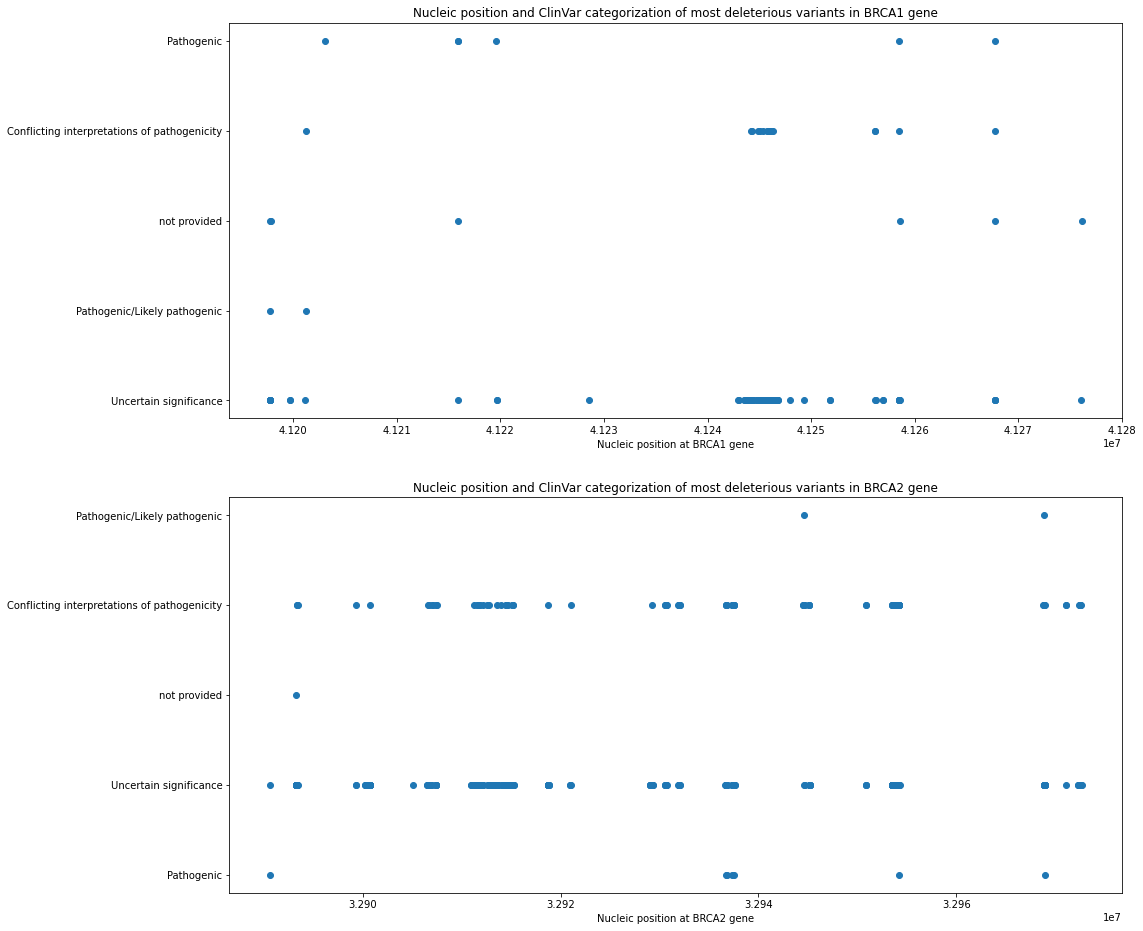

In [40]:
# nucleic positions of variants in cplt pathogen group + ClinVar annotation

fig = plt.subplots(figsize=(16, 16))

if gene_name2 != '':
    ax1 = plt.subplot(2,1,1)
    ax2 = plt.subplot(2,1,2)
    axes = [ax1, ax2]
else:
    ax1 = plt.subplot(1,1,1)
    axes = [ax1]
    
for p, g, a in zip(cplt_path_group, gene_names, axes):
    a.scatter(p['POS'], p['ClinVar_gnomAD'])
    a.set_title('Nucleic position and ClinVar categorization of most deleterious variants in ' + 
                g.upper() + ' gene')
    a.set_xlabel('Nucleic position at ' + g.upper() + ' gene')
#plt.xlabel('Nucleic position at ' + gene_name[0].upper() + ' and ' + gene_name[1].upper() + ' genes')
#plt.title('Nucleic position and ClinVar categorization of most deleterious variants in ' + gene_names[0].upper() + ' and ' + gene_names[0].upper() + ' gene');

# Deleteriousness of variants

## GnomAD Allele Frequency vs. CADD phred score

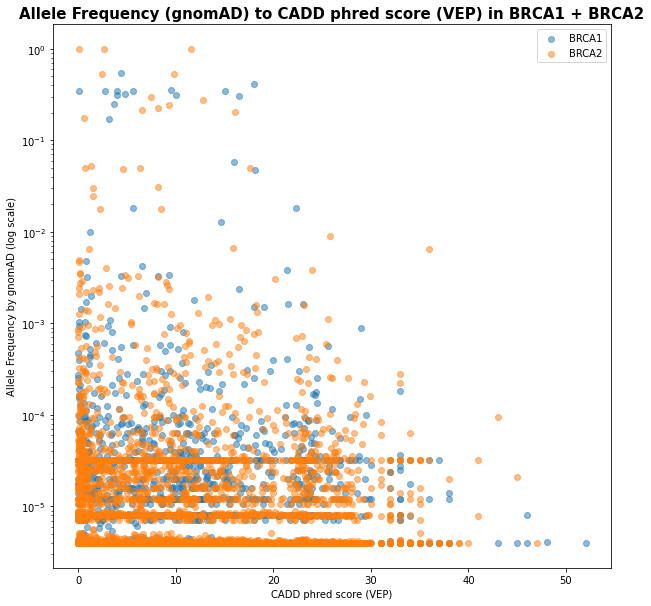

In [41]:
# allele frequency and cadd score of variants
fig = plt.figure(figsize = (10,10))
for df, g in zip(dfs, gene_names):
    plt.scatter(x = df['CADD_PHRED_VEP'], y = df['AF_gnomAD'], label = g.upper(), alpha = 0.5)
plt.yscale('log')
plt.ylabel('Allele Frequency by gnomAD (log scale)')
plt.xlabel('CADD phred score (VEP)')
plt.legend()

tit_g = (' + ').join(gene_names).upper()
plt.title(label = ('Allele Frequency (gnomAD) to CADD phred score (VEP) in ' + str(tit_g)), fontsize = 15, fontweight = 'bold');
if len(gene_names) > 1:
    plt.savefig(date + '_' + gene_names[0] + '_' + gene_names[1] + '_cadd_af.pdf')
    plt.savefig(date + '_' + gene_names[0] + '_' + gene_names[1] + '_cadd_af.jpg')
else:
    plt.savefig(date + '_' + gene_names[0] + '_cadd_af.pdf')
    plt.savefig(date + '_' + gene_names[0] + '_cadd_af.jpg')

## Division in groups for prediction of deleteriousness

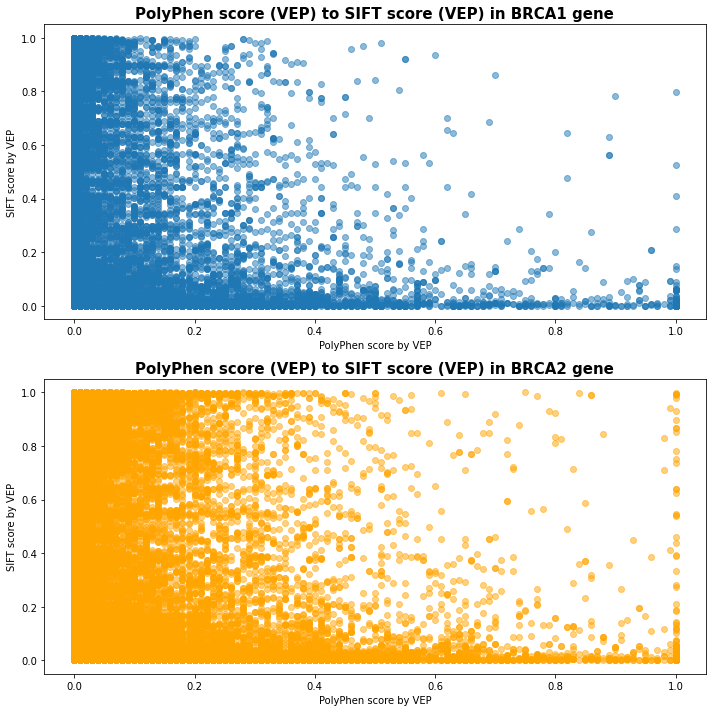

In [42]:
# SIFT_VEP vs. PolyPhen_VEP
fig = plt.subplots(figsize = (10,10))

#for df, g in zip(dfs, gene_names):
ax1 = plt.subplot(2,1,1)
ax1.set_title('PolyPhen score (VEP) to SIFT score (VEP) in ' + gene_name1.upper() + ' gene', 
              fontsize = 15, fontweight = 'bold')
ax1.scatter(x = df1['SIFT_VEP_num'], y = df1['PolyPhen_VEP_num'], 
                  label = gene_name1.upper(), alpha = 0.5)
ax1.set_ylabel('SIFT score by VEP')
ax1.set_xlabel('PolyPhen score by VEP')
#plt.legend()

ax2 = plt.subplot(2,1,2, sharey = ax1)
ax2.set_title('PolyPhen score (VEP) to SIFT score (VEP) in ' + gene_name2.upper() + ' gene', 
              fontsize = 15, fontweight = 'bold')
ax2.scatter(x = df2['SIFT_VEP_num'], y = df2['PolyPhen_VEP_num'], 
                  label = gene_name2.upper(), alpha = 0.5, c = 'orange')
ax2.set_ylabel('SIFT score by VEP')
ax2.set_xlabel('PolyPhen score by VEP')
plt.tight_layout()

plt.savefig(date + '_' + gene_names[0] + '_' + gene_names[1] + '_cadd_af.pdf')
plt.savefig(date + '_' + gene_names[0] + '_' + gene_names[1] + '_cadd_af.jpg')

#if len(gene_names) > 1:
    #plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_' + gene_names[1] + '_cadd_af.pdf')
    #plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_' + gene_names[1] + '_cadd_af.jpg')
#else:
    #plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_cadd_af.pdf')
    #plt.savefig(r'figures/' + date + '_' + gene_names[0] + '_cadd_af.jpg')

## Stop gain

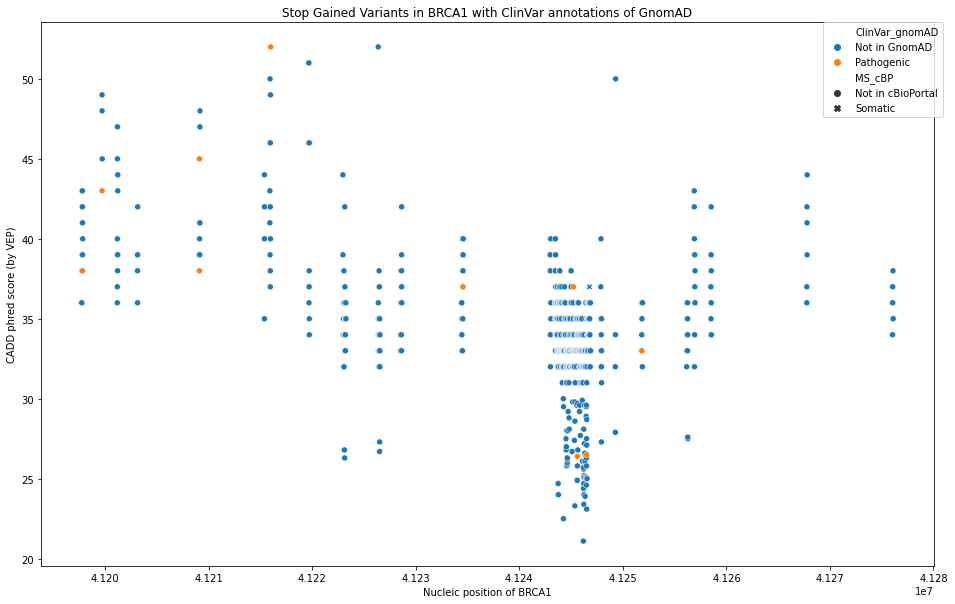

In [43]:
'''
Where are variants with gained stop codons?
Which variants are how annotated in ClinVar, which in cBioPortal?
'''

# for stop gain --> in which exons are variants with gained stop codons, which are how annotated in ClinVar, which in cBioPortal
plt.figure(figsize = (16,10))
sns.scatterplot(x = df1['POS'][df1['Consequence_VEP'] == 'stop gained'], y = df1['CADD_PHRED_VEP'][df1['Consequence_VEP'] == 'stop gained'], hue = df1['ClinVar_gnomAD'][df1['Consequence_VEP'] == 'stop gained'].fillna('Not in GnomAD'), style = df1['MS_cBP'][df1['Consequence_VEP'] == 'stop gained'].fillna('Not in cBioPortal'))
plt.title('Stop Gained Variants in ' + gene_name1.upper() + ' with ClinVar annotations of GnomAD')
plt.xlabel('Nucleic position of ' + gene_name1.upper())
plt.ylabel('CADD phred score (by VEP)')
plt.legend(bbox_to_anchor = (1.01, 1), borderaxespad = 0);
plt.savefig(date + '_' + gene_name1 + '_stop_gained.pdf')
plt.savefig(date + '_' + gene_name1 + '_stop_gained.jpg')